# Chordonomicon Data Analysis & Quality Check

This notebook analyzes the `chordonomicon_v2.csv` dataset and the processed `processed_numerals.csv` to evaluate the quality of the key detection and Roman Numeral conversion pipeline. 

**Goals:**
1.  Analyze the distribution of confidence scores from the Key Detector.
2.  Identify and visualize potential errors, focusing on low-confidence predictions.
3.  Propose and test advanced strategies like Harmonic Consistency and Modulation Detection.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from collections import Counter

# Configuration for plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

## 1. Load and Merge Data
We load both the original raw dataset and the processed output. We merge them on `id` to align the original chord sequences with our inferred keys and numerals.

In [22]:
# Load datasets
raw_df = pd.read_csv('data/chordonomicon_v2.csv', low_memory=False)
processed_df = pd.read_csv('data/processed_numerals.csv')

# Convert confidence to float
processed_df['confidence'] = pd.to_numeric(processed_df['confidence'], errors='coerce')

# Merge on 'id'
# We only keep rows that exist in processed_df (successful processing)
merged_df = pd.merge(processed_df, raw_df[['id', 'chords', 'artist_id']], on='id', how='left')

print(f"Total Processed Songs: {len(merged_df)}")
merged_df.head()

Total Processed Songs: 669498


,id,artist,key,confidence,numerals,original_chords,chords,artist_id
0,1,artist_1,C,0.97,I IV I III7 vi I IV I V7 I IV I III7 vi I IV V...,C F C E7 Am C F C G7 C F C E7 Am C F G7 C F C ...,<intro_1> C <verse_1> F C E7 Amin C F C G7 C F...,artist_1
1,2,artist_2,A,0.91,V IV I V IV I V IV I V IV I V IV I V IV I IIIb...,E D A E D A E D A E D A E D A E D A C E G D A ...,<intro_1> E D A/Cs E D A/Cs <verse_1> E D A/Cs...,artist_2
2,3,artist_3,E,0.87,vi IV vi IV vi IV vi IV V vi IV ii IV V vi IV ...,C#m A C#m A C#m A C#m A B C#m A F#m A B C#m A ...,<intro_1> Csmin <verse_1> A Csmin A Csmin A Cs...,artist_3
3,4,artist_4,D,0.97,I Imaj7 I Imaj7 ii V I IV ii V I IV ii V I IV ...,D Dmaj7 D Dmaj7 Em A D G Em A D G Em A D G Em ...,<intro_1> D Dmaj7 D Dmaj7 <verse_1> Emin A D G...,artist_4
4,5,artist_5,G,0.91,IV I IV I IV VIIb v I v I IV I IV VIIb v I v I...,C G C G C F Dm G Dm G C G C F Dm G Dm G C F Dm...,<intro_1> C <verse_1> G C G C <chorus_1> F Dmi...,artist_5


## 2. Confidence Analysis
How confident is our Key Detector? We expect a bimodal distribution: high confidence for simple pop songs, lower for complex/jazz songs.

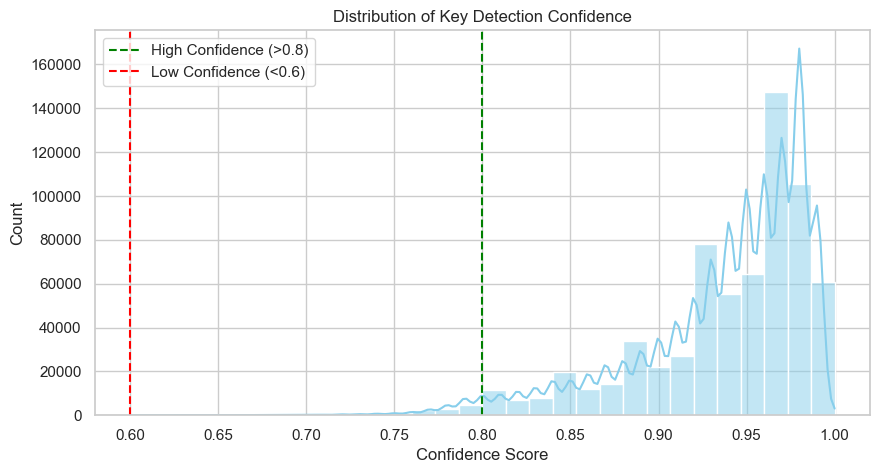

In [4]:
# Histogram of Confidence
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['confidence'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Key Detection Confidence')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.axvline(0.8, color='green', linestyle='--', label='High Confidence (>0.8)')
plt.axvline(0.6, color='red', linestyle='--', label='Low Confidence (<0.6)')
plt.legend()
plt.show()

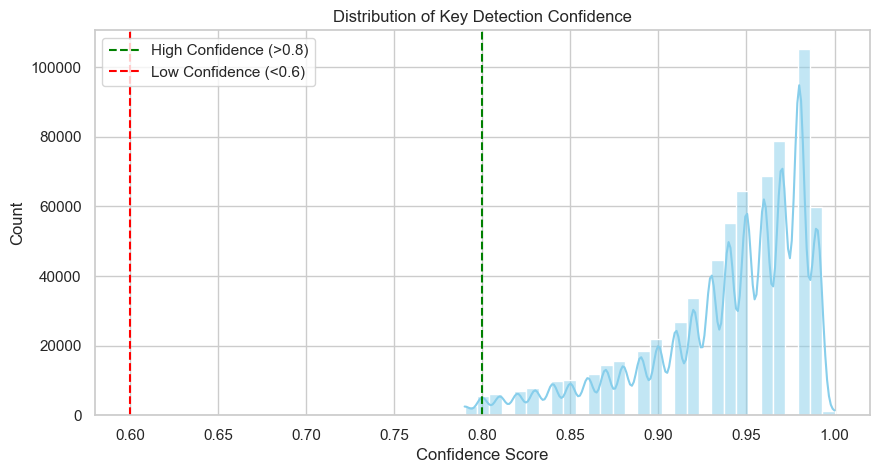

In [23]:
# Histogram of Confidence after removing <0.79 confidence entries
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['confidence'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Key Detection Confidence')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.axvline(0.8, color='green', linestyle='--', label='High Confidence (>0.8)')
plt.axvline(0.6, color='red', linestyle='--', label='Low Confidence (<0.6)')
plt.legend()
plt.show()

In [5]:
# Bucketing
high_conf = merged_df[merged_df['confidence'] > 0.8]
mid_conf = merged_df[(merged_df['confidence'] >= 0.6) & (merged_df['confidence'] <= 0.8)]
low_conf = merged_df[merged_df['confidence'] < 0.6]

print(f"High Confidence (> 0.8): {len(high_conf)} ({len(high_conf)/len(merged_df):.1%})")
print(f"Mid Confidence (0.6-0.8): {len(mid_conf)} ({len(mid_conf)/len(merged_df):.1%})")
print(f"Low Confidence (< 0.6):  {len(low_conf)} ({len(low_conf)/len(merged_df):.1%})")

High Confidence (> 0.8): 661096 (97.3%)
Mid Confidence (0.6-0.8): 18106 (2.7%)
Low Confidence (< 0.6):  0 (0.0%)


In [26]:
# Bucketing
high_conf = merged_df[merged_df['confidence'] >= 0.8]
mid_conf = merged_df[(merged_df['confidence'] >= 0.6) & (merged_df['confidence'] < 0.8)]
low_conf = merged_df[merged_df['confidence'] < 0.6]

print(f"High Confidence (> 0.8): {len(high_conf)} ({len(high_conf)/len(merged_df):.1%})")
print(f"Mid Confidence (0.6-0.8): {len(mid_conf)} ({len(mid_conf)/len(merged_df):.1%})")
print(f"Low Confidence (< 0.6):  {len(low_conf)} ({len(low_conf)/len(merged_df):.1%})")

High Confidence (> 0.8): 666725 (99.6%)
Mid Confidence (0.6-0.8): 2773 (0.4%)
Low Confidence (< 0.6):  0 (0.0%)


## 3. Error Analysis: The "Uncanny Valley" (0.6 - 0.7)
Songs with confidence between 0.6 and 0.7 are the most interesting. They aren't complete failures (which might be noise), but they aren't clear successes. These often contain modulations or ambiguous centers.

Let's visualize the alignment between the **Cleaned Original Chords** and the **Roman Numerals** for a few of these songs to spot issues.

In [12]:
def clean_chord_simple(chord_str):
    """Simplified cleaner to match data_processing logic for visualization"""
    if not isinstance(chord_str, str) or chord_str.startswith('<'): return None
    chord_str = chord_str.replace('sus', 'SUS').replace('s', '#').replace('SUS', 'sus')
    if '/' in chord_str: chord_str = chord_str.split('/')[0]
    for suffix in ['no3d', 'no5', '(b5)']:
        chord_str = chord_str.replace(suffix, '')
    return chord_str.replace('min', 'm')

def visualize_alignment(row, num_chords=100):
    print(f"\nID: {row['id']} | Artist: {row['artist_id']} | Key: {row['key']} | Conf: {row['confidence']}")
    
    # Re-clean original chords to match the numerals length/content
    raw_tokens = str(row['chords']).split()
    cleaned_tokens = [clean_chord_simple(t) for t in raw_tokens]
    cleaned_tokens = [c for c in cleaned_tokens if c] # Remove Nones
    
    numerals = str(row['numerals']).split()
    
    # Print aligned
    # Truncate for display
    limit = min(len(cleaned_tokens), len(numerals), num_chords)
    
    print(f"{'Original':<10}: ", end="")
    for c in cleaned_tokens[:limit]:
        print(f"{c:<6}", end="")
    print()
    
    print(f"{'Numerals':<10}: ", end="")
    for n in numerals[:limit]:
        print(f"{n:<6}", end="")
    print()

# Sample 5 songs from the Mid-Confidence range
sample_mid = mid_conf.sample(5, random_state=122)
for _, row in sample_mid.iterrows():
    visualize_alignment(row)


ID: 99790 | Artist: artist_34027 | Key: A | Conf: 0.77
Original  : Amaj7 D7    Gmaj7 C#    Amaj7 D7    Gmaj7 C#    Amaj7 D7    Gmaj7 C#    Amaj7 D7    Gmaj7 C#    Dmaj7 G#m   F#    Dmaj7 G#m   F#    C#    D#m   C#    D#m   
Numerals  : Imaj7 IV7   VIIbmaj7III   Imaj7 IV7   VIIbmaj7III   Imaj7 IV7   VIIbmaj7III   Imaj7 IV7   VIIbmaj7III   IVmaj7vii   VI    IVmaj7vii   VI    III   iv#   III   iv#   

ID: 407374 | Artist: artist_2083 | Key: F | Conf: 0.76
Original  : F     Bb    F     Bb    F     Bb    F     Bb    F     Bb    F     Bb    F     Bb    F     Bb    F     Bb    F     Bb    F     Bb    F     C     F     Bb    C     F     Bb    C     F     Bb    C     F     Bb    F     Bb    F     Bb    F     Bb    F     Bb    F     Bb    F     Bb    F     Bb    F     Bb    F     C     F     Bb    C     F     Bb    C     F     Bb    C     F     Bb    F     Bb    F     C     Bb    Eb    Bb    F     C     F     Bb    Eb    Bb    F     Bb    C     Bb    C     F     Bb    C     F     Bb    C     Bb

## 5. Advanced Strategy: Modulation Detection (Segmented Analysis)
Many "bad" songs likely modulate (change key). A single global key is insufficient.
**Strategy**: Split the song into 4 equal chunks. Detect the key for each chunk. If the keys differ significantly, the song modulates.

We will simulate this on a subset of data.

In [17]:
# Prefer importing from the package where data_processing lives
from src.music.key_detector_major import KeyDetector

# If key_detector_major.py is next to the notebook instead, uncomment:
# import sys, os
# sys.path.append(os.getcwd())
# from key_detector_major import KeyDetector
from data_processing import get_notes_from_chords, clean_chord

def check_modulation(row):
    """Returns True if modulation is suspected (different keys in chunks)"""
    raw_chords = str(row['chords']).split()
    clean_chords = [clean_chord(c) for c in raw_chords]
    clean_chords = [c for c in clean_chords if c]
    
    if len(clean_chords) < 16: return False # Too short to split
    
    # Split into 3 chunks (Beginning, Middle, End)
    chunk_size = len(clean_chords) // 3
    chunks = [
        clean_chords[:chunk_size],
        clean_chords[chunk_size:2*chunk_size],
        clean_chords[2*chunk_size:]
    ]
    
    detected_keys = []
    detector = KeyDetector()
    
    for chunk in chunks:
        notes = get_notes_from_chords(chunk)
        if not notes: continue
        key, conf = detector.detect(notes)
        if key:
            detected_keys.append(key)
            
    # If we have different keys with high confidence, it's a modulation
    unique_keys = set(detected_keys)
    return len(unique_keys) > 1, detected_keys

# Test on low confidence songs
sample_low = mid_conf.head(20)
for _, row in sample_low.iterrows():
    is_modulating, keys = check_modulation(row)
    if is_modulating:
        print(f"Song {row['id']} (Conf {row['confidence']}) (Detected key {row['key']}) likely modulates: {keys}")

Song 119 (Conf 0.8) (Detected key E) likely modulates: ['C', 'E', 'E']
Song 126 (Conf 0.79) (Detected key D) likely modulates: ['D', 'A#', 'D#']
Song 140 (Conf 0.72) (Detected key G) likely modulates: ['E', 'G', 'C']
Song 187 (Conf 0.76) (Detected key C#) likely modulates: ['G#', 'A', 'C#']
Song 307 (Conf 0.8) (Detected key A) likely modulates: ['F#', 'A', 'A']
Song 378 (Conf 0.76) (Detected key C) likely modulates: ['C', 'E', 'E']
Song 395 (Conf 0.8) (Detected key A#) likely modulates: ['F', 'C', 'F']
Song 465 (Conf 0.76) (Detected key E) likely modulates: ['B', 'E', 'E']
Song 624 (Conf 0.79) (Detected key F) likely modulates: ['F', 'F', 'A#']
Song 736 (Conf 0.79) (Detected key B) likely modulates: ['B', 'B', 'G']
